In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from numpy.linalg import inv
from scipy.linalg import eigh
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

# Diffusion map

In [9]:
def eta(D):
    eta = 0.05*np.amax(D)
    return eta


def kernel_matrix(D, eta):
    return np.exp(-D**2/eta)


def diagonal_normalization(kernel_matrix):
    diagonal_normalization = np.zeros(kernel_matrix.shape)
    for i in range(kernel_matrix.shape[0]):
        diagonal_normalization[i][i] = sum(kernel_matrix[i])
    return diagonal_normalization


def diffusion_map(X, nb_eigen, alpha):
    
    D = euclidean_distances(X, X)
    eta = alpha*np.amax(D)
    W = np.exp(-D**2/eta)
    P = diagonal_normalization(W)
    K = np.dot(np.dot(inv(P),W),inv(P))
    Q = diagonal_normalization(K)
    T = np.dot(np.dot(inv(Q)**(1/2), K),inv(Q)**(1/2))
    
    eigen_values, eigen_vectors = eigh(T)
    idx = eigen_values.argsort()[::-1][:nb_eigen]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:,idx]
    
    eigen_values = eigen_values**(1/eta)
    eigen_vectors = np.matmul(inv(Q)**(1/2), eigen_vectors)

    
    return eigen_vectors, eigen_values
   

In [10]:
def create_diffusion_map(X, L):
    #Step 1
    N = X.shape[0]
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distance = (X[i] - X[j])
            D[i][j] = math.sqrt(np.sum(distance * distance))
    #Step 2
    epsilon = 0.05 * np.max(D)
    #Step 3
    W = np.exp(-np.power(D, 2)/epsilon)
    #Step 4
    P = np.zeros((N, N))
    for i in range(N):
        P[i,i] = np.sum(W[i])
    #Step 5
    inv_P = LA.inv(P)
    K = inv_P.dot(W.dot(inv_P))
    #Step 6
    Q = np.zeros((N, N))
    for i in range(N):
        Q[i,i] = np.sum(K[i])
    #Step 7
    inv_Q_sqrt = np.sqrt(LA.inv(Q))
    T = inv_Q_sqrt.dot(K.dot(inv_Q_sqrt))
    #Step 8
    a, v = eigsh(T,k=L+1)
    #Step 9
    _lambda = np.sqrt(np.power(a, 1/epsilon))
    #Step 10
    _phi = inv_Q_sqrt.dot(v)
    return _lambda, _phi

In [12]:
#distance_matrix = geom.compute_adjacency_matrix()

# Test on the CIFAR-10 dataset

In [13]:
import pickle
import os
import platform

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 32, 32, 3) #np.transpose(np.reshape(single_img,(3, 32,32)), (1,2,0))
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = "cifar-10-batches-py/"
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255

    return x_train, y_train, X_val, y_val, x_test, y_test

In [14]:
x_train, y_train, X_val, y_val, x_test, y_test = get_CIFAR10_data()

In [15]:
for i in range(x_train.shape[0]):
    x_train[i] = np.transpose(x_train[i].reshape(3,32,32), (1,2,0))

Label : truck


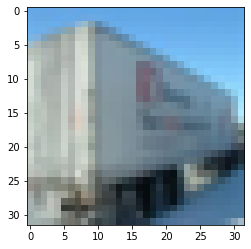

In [16]:
# Visualising a sample #
sample = 15
#plt.imshow(np.transpose(x_train[nb_sample].reshape(3,32,32), (1,2,0)))
plt.imshow(x_train[sample])
print('Label : {}'.format(classes[y_train[sample]]))
plt.show()

# Reducing images in gray

In [17]:
x_train_gray = np.zeros((49000, 32, 32))

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.reshape(32, 32)

for i in range(x_train_gray.shape[0]):
    x_train_gray[i] = rgb2gray(x_train[i])

Label : truck


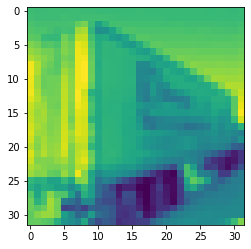

In [18]:
# Visualising a sample #
plt.imshow(x_train_gray[sample])
print('Label : {}'.format(classes[y_train[sample]]))
plt.show()

### Diffusion map

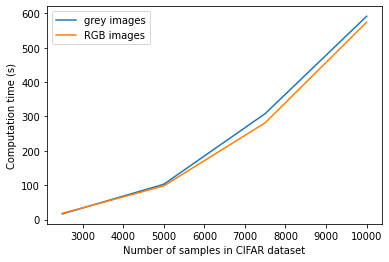

In [9]:
# Results on gray dataset for eta= 0.01 and nb_eigen vectors =300#
list_samples = [2500,5000,7500,10000]
computation_time_gray = [16.40, 102.64, 308.33, 591.66]
computation_time_color = [18.15, 97.7900, 281.66, 574.35]
plt.plot(list_samples, computation_time_gray, label='grey images')
plt.plot(list_samples, computation_time_color, label='RGB images')
plt.xlabel('Number of samples in CIFAR dataset')
plt.ylabel('Computation time (s)')
plt.legend()
plt.show()

In [19]:
nb_samples = 1000
#x_batch = x_train_gray[0:nb_samples].reshape(nb_samples,-1)
x_batch = x_train[0:nb_samples].reshape(nb_samples,-1)
x_batch.shape



(1000, 3072)

In [22]:
import time

t0 = time.time()
eigen_functions, eigen_values = diffusion_map(x_batch, 300, 0.1)
print(time.time()-t0)

2.342945098876953


In [21]:
eigen_functions.shape

(1000, 300)

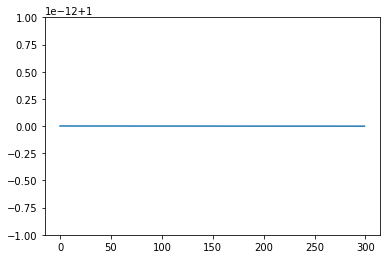

In [13]:
plt.plot(eigen_values[0:300])
plt.show()

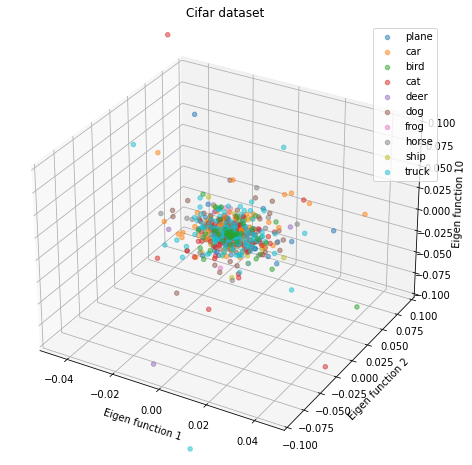

In [24]:
eigenvalue_1 = 1
eigenvalue_2 = 2
eigenvalue_3 = 10

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


for j in range(0,10):
    indices = [i for i, x in enumerate(y_train[0:nb_samples]) if x == j]
    ax.scatter(eigen_functions[indices, eigenvalue_1], eigen_functions[indices, eigenvalue_2], eigen_functions[indices, eigenvalue_3], c=colors[j], label=classes[j], alpha=0.5)
ax.set_xlabel("Eigen function {}".format(eigenvalue_1))
ax.set_ylabel("Eigen function {}".format(eigenvalue_2))
ax.set_zlabel("Eigen function {}".format(eigenvalue_3))
ax.set_title('Cifar dataset')
ax.set_xlim3d(-0.05, 0.05)
ax.set_ylim3d(-0.1, 0.1)
ax.set_zlim3d(-0.1, 0.1)
ax.legend()
plt.show()

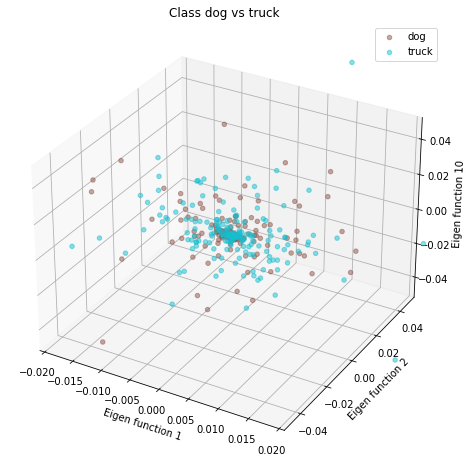

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors


fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
eigenvalue_1 = 1
eigenvalue_2 = 2
eigenvalue_3 = 10


for j in [5,9]:
    indices = [i for i, x in enumerate(y_train[0:nb_samples]) if x == j]
    ax.scatter(eigen_functions[indices, eigenvalue_1], eigen_functions[indices, eigenvalue_2], eigen_functions[indices, eigenvalue_3], c=colors[j], label=classes[j], alpha=0.5)
ax.set_xlabel("Eigen function {}".format(eigenvalue_1))
ax.set_ylabel("Eigen function {}".format(eigenvalue_2))
ax.set_zlabel("Eigen function {}".format(eigenvalue_3))
ax.set_title('Class {} vs {}'.format(classes[5], classes[9]))
ax.set_xlim3d(-0.02, 0.02)
ax.set_ylim3d(-0.05, 0.05)
ax.set_zlim3d(-0.05, 0.05)
ax.legend()
plt.show()

In [27]:
selection = LocalRegressionSelection(intrinsic_dim=3, n_subsample=1999, strategy="dim").fit(eigen_functions[:,:20])
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")

Found parsimonious eigenvectors (indices): [1 2 7]


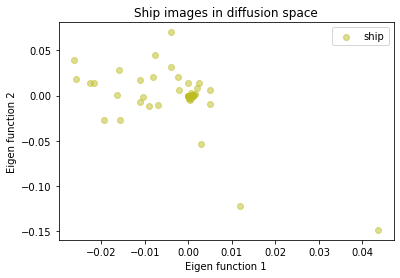

In [62]:
j = 8
indices = [i for i, x in enumerate(y_train[0:nb_samples]) if x == j]
plt.scatter(eigen_functions[indices, eigenvalue_1], eigen_functions[indices, eigenvalue_2], c=colors[j], label=classes[j], alpha=0.5)
plt.legend()
plt.xlabel("Eigen function {}".format(eigenvalue_1))
plt.ylabel("Eigen function {}".format(eigenvalue_2))
plt.title('Ship images in diffusion space')
plt.show()

# Datafold - 2000 samples

In [14]:
# NOTE: make sure "path/to/datafold" is in sys.path or PYTHONPATH if datafold is not installed
import datafold.dynfold as dfold
import datafold.pcfold as pfold
from datafold.utils.plot import plot_pairwise_eigenvector
from datafold.dynfold import LocalRegressionSelection


In [15]:
X = x_batch
n_eigeinpairs = 10

nr_samples = X.shape[0]
idx_plot= np.random.permutation(nr_samples)[0:nr_samples]

X_pcm = pfold.PCManifold(X)
X_pcm.optimize_parameters()

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

epsilon=17.904158782344158, cut-off=18.16058349609375


In [16]:
dmap = dfold.DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                           n_eigenpairs=n_eigeinpairs,
                           dist_kwargs=dict(cut_off=X_pcm.cut_off))
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

#plot_pairwise_eigenvector(eigenvectors=dmap.eigenvectors_[idx_plot, :], n=1,
#                          fig_params=dict(figsize=[15,15]),
#                          scatter_params=dict(cmap=plt.cm.Spectral, c=X_color[idx_plot]))

In [17]:
selection = LocalRegressionSelection(intrinsic_dim=3, n_subsample=1999, strategy="dim").fit(dmap.eigenvectors_)
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")

Found parsimonious eigenvectors (indices): [1 6 7]


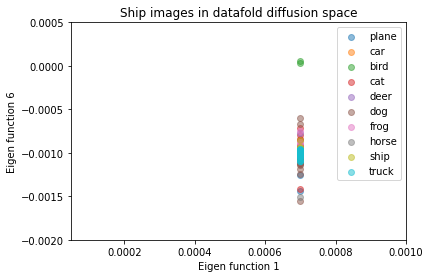

In [33]:
eigenvalue_1 = 1
eigenvalue_2 = 6
#eigenvalue_3 = 10
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for j in range(0,10):
    indices = [i for i, x in enumerate(y_train[0:nb_samples]) if x == j]
    plt.scatter(dmap.eigenvectors_[indices, eigenvalue_1], dmap.eigenvectors_[indices, eigenvalue_2], c=colors[j], label=classes[j], alpha=0.5)
plt.legend()

plt.xlabel("Eigen function {}".format(eigenvalue_1))
plt.ylabel("Eigen function {}".format(eigenvalue_2))
plt.xlim(0.00005, 0.001)
plt.ylim(-0.0020, 0.0005)
plt.title('Ship images in datafold diffusion space')
plt.show()

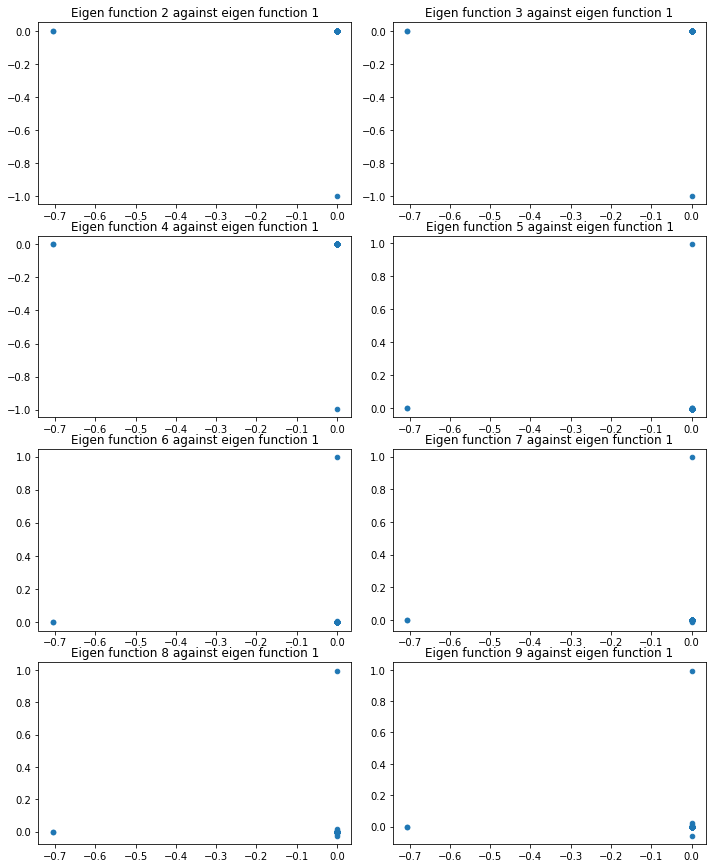

In [37]:
fig, axs = plt.subplots(4,2, figsize=(10, 12))
fig.tight_layout()
colors = cm.rainbow(np.linspace(0, 1, 3072))
for i in range(0,8):  #eigen_functions.shape[1]-2):
    axs[int((i)/2),(i)%2].scatter(dmap.eigenvectors_[:,1], dmap.eigenvectors_[:,i+2], s=21)
    axs[int((i)/2),(i)%2].title.set_text('Eigen function {} against eigen function 1'.format(i+2))
plt.title
plt.show()

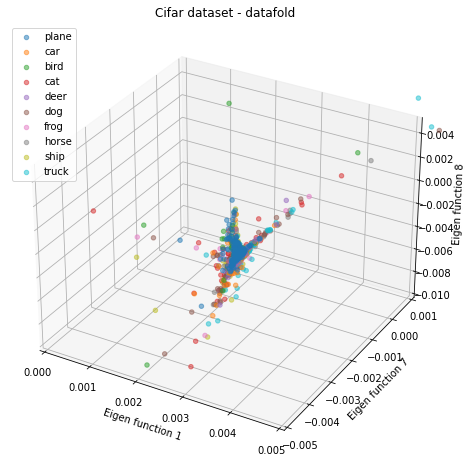

In [63]:
eigenvalue_1 = 1
eigenvalue_2 = 7
eigenvalue_3 = 8

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


for j in range(0,10):
    indices = [i for i, x in enumerate(y_train[0:nb_samples]) if x == j]
    ax.scatter(dmap.eigenvectors_[indices, eigenvalue_1], dmap.eigenvectors_[indices, eigenvalue_2], dmap.eigenvectors_[indices, eigenvalue_3], c=colors[j], label=classes[j], alpha=0.5)
ax.set_xlabel("Eigen function {}".format(eigenvalue_1))
ax.set_ylabel("Eigen function {}".format(eigenvalue_2))
ax.set_zlabel("Eigen function {}".format(eigenvalue_3))
ax.set_title('Cifar dataset - datafold')
ax.set_xlim3d(0, 0.005)
ax.set_ylim3d(-0.005, 0.001)
ax.set_zlim3d(-0.01, 0.005)
ax.legend()
plt.show()

# Toutes les samples

In [10]:
nb_samples = 20000
x_batch = x_train_gray[0:nb_samples].reshape(nb_samples,-1)
#x_batch = x_train.reshape(49000,-1)
x_batch = np.asarray(x_batch, dtype=np.float32)
x_batch[0]

array([0.24004354, 0.17641059, 0.1883255 , ..., 0.73933494, 0.48618004,
       0.38814393], dtype=float32)

In [11]:
import time

t0 = time.time()
eigen_functions, eigen_values = create_diffusion_map(x_batch, 100)
print(time.time()-t0)

NameError: name 'LA' is not defined

In [30]:
nb_samples = 20000

x_batch = x_train_gray[0:nb_samples].reshape(nb_samples,-1)
X = x_batch
n_eigeinpairs = 10

nr_samples = X.shape[0]
idx_plot= np.random.permutation(nr_samples)[0:nr_samples]

X_pcm = pfold.PCManifold(X)
X_pcm.optimize_parameters()

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

epsilon=5.611456437634597, cut-off=10.166948782514012


In [ ]:
t0 = time.time()
dmap = dfold.DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                           n_eigenpairs=n_eigeinpairs,
                           dist_kwargs=dict(cut_off=X_pcm.cut_off))
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_
print(time.time()-t0)


In [129]:
eigen_functions, eigen_values = diffusion_map(x_image, 10, 0.05)

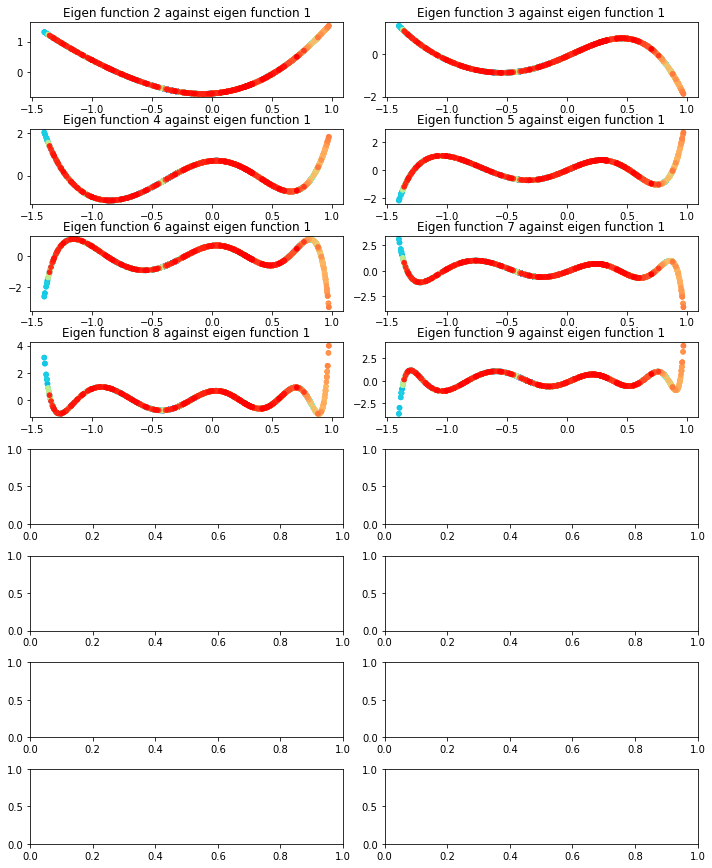

In [131]:
fig, axs = plt.subplots(8,2, figsize=(10, 12))
fig.tight_layout()
colors = cm.rainbow(np.linspace(0, 1, 3072))
for i in range(0,8):  #eigen_functions.shape[1]-2):
    axs[int((i)/2),(i)%2].scatter(eigen_functions[:,1], eigen_functions[:,i+2], c=colors, cmap=plt.cm.Spectral, s=21)
    axs[int((i)/2),(i)%2].title.set_text('Eigen function {} against eigen function 1'.format(i+2))
plt.title
plt.show()